In [6]:
import bempp.api
import numpy as np
import scipy
import math
import time
import scipy.linalg 
import scipy.linalg.interpolative as sli
%matplotlib inline
from matplotlib import pyplot as plt
bempp.api.enable_console_logging()

<StreamHandler stderr (DEBUG)>

In [35]:
grid = bempp.api.shapes.regular_sphere(3)
print(f"Number of elements: {grid.number_of_elements}")

Number of elements: 512


In [36]:
vert1 = grid.vertices.copy()    # Vertices of sphere1
rows = vert1.shape[0]
cols = vert1.shape[1]

vert11 = np.zeros((rows,cols))  # Shift these vertices horizontally
for i in range(cols):
    vert11[0,i] = -1
    
vert2 = vert1 + vert11          # Construct the vertices for sphere2

In [37]:
"""Create two unit spheres"""
elt = grid.elements.copy()        # Elements of sphere1
verts = np.hstack([vert1,vert2])  # Combine vertices of two spheres
elts = np.hstack([elt,elt+cols])  # Combine elements of two spheres
new_grid = bempp.api.grid.grid.Grid(verts, elts) # Create new grid

In [38]:
wavenumber = 3*1j 

In [39]:
rwg = bempp.api.function_space(new_grid,'RWG',0) 
snc = bempp.api.function_space(new_grid,'SNC',0)

In [40]:
mat = bempp.api.operators.boundary.maxwell.electric_field(rwg, rwg, snc, wavenumber).weak_form().A

root:INFO: Regular kernel vector length: 8 (double precision)
root:INFO: Regular kernel runtime [ms]: 69.76760800000001
root:INFO: Singular kernel runtime [ms]: 176.013635


In [41]:
mat.shape

(1536, 1536)

In [42]:
from bempp.api.utils import Octree # Construct the Octree in order to reorder the matrix

vertices = np.empty((3,rwg.global_dof_count),np.float64)
for index in range(rwg.global_dof_count):
    elem,local_id = rwg.global2local[index][0]
    edge_id = new_grid.element_edges[local_id,elem]
    vertices[:,index] = .5*(new_grid.vertices[:,new_grid.edges[0,edge_id]] + new_grid.vertices[:,new_grid.edges[1,edge_id]])
    
box = new_grid.bounding_box
tree = Octree(box[:,0],box[:,1],2,vertices)

In [43]:
sorted_indices = tree.sorted_indices

In [44]:
n = mat.shape[0]
nboxes = 48
size = n // nboxes

In [45]:
sorted_mat = np.real(mat[:, sorted_indices][sorted_indices, :])

sorted_mat_inf = np.zeros((n,n))
sorted_mat_inf[0:n//2,0:n//2] = sorted_mat[0:n//2,0:n//2]
sorted_mat_inf[n//2:,n//2:] = sorted_mat[n//2:,n//2:]

In [20]:
Eigs1,evals1 = np.linalg.eig(sorted_mat)

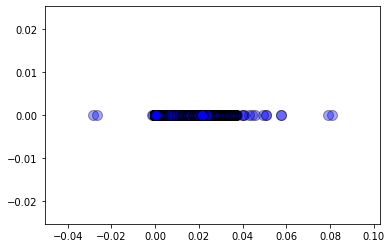

In [21]:
plt.scatter(np.real(Eigs1),np.imag(Eigs1),color='b', s=100, alpha=.1, edgecolors='black')

In [22]:
Eigs2,evals2 = np.linalg.eig(sorted_mat_inf)

Text(0.5, 1.0, 'EFIE_weak for $A_{\\infty}$')

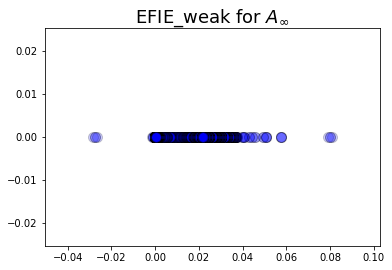

In [23]:
plt.scatter(np.real(Eigs2),np.imag(Eigs2),color='b', s=100, alpha=.1, edgecolors='black')
plt.title('EFIE_weak for $A_{\infty}$', fontsize = 18)

In [24]:
def get_box(nx, ny, sorted_mat, nboxes, n):
    """Return the content of a given box"""
    xrange = [nx * size, (1 + nx) * size] 
    yrange = [ny * size, (1 + ny) * size] 
    return sorted_mat[xrange[0]:xrange[1], yrange[0]:yrange[1]] 

In [25]:
def get_con_box(i,sorted_mat,nboxes,n):
    BB = sorted_mat[i * size : (i + 1) * size, :]
    B = np.delete(BB, np.s_[i*size : (i+1)*size], axis = 1)
    
    CC = np.transpose(sorted_mat[:, i * size : (i + 1) * size])
    C = np.delete(CC, np.s_[i*size : (i+1)*size], axis = 1)
    return np.hstack((B,C))

In [26]:
def L(i,k,sorted_mat,nboxes,n):
    idx1,proj1 = sli.interp_decomp(get_con_box(i,sorted_mat,nboxes,n), k, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box(i,sorted_mat,nboxes,n),k,idx1)
    B1_trans = np.transpose(B1)
    
    idx2,proj2 = sli.interp_decomp(B1_trans, k, rand = False)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    P2 = np.transpose(P2_trans)
    return P2,idx2

In [27]:
def index_set(k,sorted_mat,nboxes,n):
    l = []
    for i in range(nboxes):
        l.append(L(i,k,sorted_mat,nboxes,n)[1][0:k])
    return l

In [28]:
def S(k,sorted_mat,nboxes,n):
    ll = index_set(k,sorted_mat,nboxes,n)
    mat__ = np.zeros((k*nboxes,k*nboxes))
    for i in range(nboxes):
        for j in range(nboxes):
            if i != j:
                mat_ = get_box(i,j,sorted_mat,nboxes,n)[ll[i],:]
                mat__[i*k:(i+1)*k,j*k:(j+1)*k] = mat_[:,ll[j]]
    return mat__

In [29]:
def R(i,k,sorted_mat,nboxes,n):
    RR = np.transpose(L(i,k,sorted_mat,nboxes,n)[0])
    return RR

In [30]:
def new_S(k,sorted_mat,nboxes,n):
    mat_ = S(k,sorted_mat,nboxes,n)
    for i in range(nboxes):
        mat_[i*k:(i+1)*k,i*k:(i+1)*k] = np.linalg.inv(R(i,k,sorted_mat,nboxes,n) @ np.linalg.inv(get_box(i,i,sorted_mat,nboxes,n)) @ L(i,k,sorted_mat,nboxes,n)[0])
    return mat_

In [31]:
def logdet_method2(k,sorted_mat,nboxes,n):
    a1 = 0
    p1,l1,u1 = scipy.linalg.lu(new_S(k,sorted_mat,nboxes,n))
    for i in range(k*nboxes):
        a1 += math.log(abs(u1[i,i]))
        
    a2 = 0
    for i in range (nboxes):
        p2,l2,u2 = scipy.linalg.lu(get_box(i,i,sorted_mat,nboxes,n))
        for j in range(size):
            a2 +=math.log(abs(u2[j,j]))
            
    a3 = 0
    for i in range(nboxes):
        p3,l3,u3 = scipy.linalg.lu(-R(i,k,sorted_mat,nboxes,n)@np.linalg.inv(get_box(i,i,sorted_mat,nboxes,n)) @L(i,k,sorted_mat,nboxes,n)[0] )
        for j in range(k):
            a3 += math.log(abs(u3[j,j]))
    return a1 + a2 + a3

In [46]:
"""Level 3 exact value"""
P3,L3,U3 = scipy.linalg.lu(sorted_mat)

logdet3 = 0
for i in range(n):
    logdet3 += math.log(abs(U3[i,i]))
print (logdet3)

-6060.4296016375965


In [ ]:
"""Level 3 approx value"""
l3_det = []
for i in range(1,size+1):
    l3_det.append(logdet_method2(i,sorted_mat,nboxes,n))

In [ ]:
""" Level 3 relative error ---- rank converge"""
relative_error_3 = []
for i in range(size):
    relative_error_3.append(np.log10(abs((l3_det[i]-logdet3)/logdet3)))
k_det = np.linspace(1,size+1,size)

plt.plot(k_det,relative_error_3, color = 'red', linewidth = 1.0, linestyle = '--')
plt.xlabel('rank')
plt.ylabel('relative error')
plt.legend(['level 3'])
plt.show()

In [47]:
"""Level 3 exact value of $A_{\infty}$"""
P33,L33,U33 = scipy.linalg.lu(sorted_mat_inf)

logdet33 = 0
for i in range(n):
    logdet33 += math.log(abs(U33[i,i]))
print (logdet33)

-5971.646943739546


In [48]:
logdet3 - logdet33

-88.78265789805027

In [ ]:
"""Level 3 approx value of $A_{\infty}$"""
l33_det = []
for i in range(1,size+1):
    l33_det.append(logdet_method2(i,sorted_mat,nboxes,n))

In [ ]:
"""Level 3 relative error of computing the difference"""
relative_error_33 = []
for i in range(size):
    a = abs(((l3_det[i] - l33_det[i])-(logdet3-logdet33))/(logdet3-logdet33))
    relative_error_33.append(np.log10(a))
k_det = np.linspace(1,size+1,size)


plt.plot(k_det,relative_error_33,color='red',linewidth=1.0,linestyle='--')


plt.legend(['diff-appro','diff-exact'])

plt.ylabel('log10 of the relative error--Level 3')
plt.xlabel('rank')
plt.show()

In [32]:
"""Level 4 exact value"""
P4,L4,U4 = scipy.linalg.lu(sorted_mat)

logdet4 = 0
for i in range(n):
    logdet4 += math.log(abs(U4[i,i]))
print (logdet4)

-31299.088233437764


In [33]:
"""Level 4 exact value of $A_{\infty}$"""
P44,L44,U44 = scipy.linalg.lu(sorted_mat_inf)

logdet44 = 0
for i in range(n):
    logdet44 += math.log(abs(U44[i,i]))
print (logdet44)

-30965.799988131155


In [34]:
logdet4 - logdet44

-333.2882453066086

In [ ]:
"""Level 4 approx value"""
l4_det = []
for i in range(1,size+1):
    l4_det.append(logdet_method2(i,sorted_mat,nboxes,n))

In [ ]:
"""Level 4 relative error ---- rank converge"""
relative_error_4 = []
for i in range(size):
    relative_error_4.append(np.log10(abs((l4_det[i]-logdet4)/logdet4)))
    
k_det = np.linspace(1,size+1,size)
plt.plot(k_det,relative_error_3, color = 'red', linewidth = 1.0, linestyle = '--')
plt.plot(k_det,relative_error_4, color = 'orange', linewidth = 1.0, linestyle = '--')
plt.xlabel('rank')
plt.ylabel('relative error')
plt.legend(['level 3','level 4'])
plt.show()

In [ ]:
"""Level 4 approx value of $A_{\infty}$"""
l44_det = []
for i in range(1,size+1):
    l44_det.append(logdet_method2(i,sorted_mat,nboxes,n))

In [ ]:
"""Level 4 relative error of computing the difference"""
relative_error_44 = []
for i in range(size):
    a = abs(((l4_det[i] - l44_det[i])-(logdet4-logdet44))/(logdet4-logdet44))
    relative_error_44.append(np.log10(a))
k_det = np.linspace(1,size+1,size)

plt.plot(k_det,relative_error_33,color='red',linewidth=1.0,linestyle='--')

plt.plot(k_det,relative_error_44,color='orange',linewidth=1.0,linestyle='--')


plt.legend(['level 3','level 4'])

plt.ylabel('log10 of the relative error')
plt.xlabel('rank')
plt.show()

In [109]:
"""Level 5 exact value"""
P5,L5,U5 = scipy.linalg.lu(sorted_mat)

logdet5 = 0
for i in range(n):
    logdet5 += math.log(abs(U5[i,i]))
print (logdet5)

-153442.1244564465


In [111]:
"""Level 5 exact value of $A_{\infty}$"""
P55,L55,U55 = scipy.linalg.lu(sorted_mat)

logdet55 = 0
for i in range(n):
    logdet55 += math.log(abs(U55[i,i]))
print (logdet55)

-152224.06475212605


In [93]:
A3 =  -39.57114200099977 
A4 = -183.61418038781449
A5 = -629.2506767645391
B3 = 768
B4 = 3072
B5 = 12288

Text(0.5, 1.0, 'One sphere')

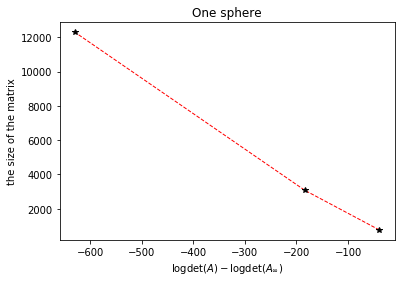

In [119]:
A = [A3,A4,A5]
B = [B3,B4,B5]
plt.plot(A,B,color='red',linewidth=1.0,linestyle='--')
plt.plot(A,B,'k*')

plt.xlabel('$\log\det(A)-\log\det(A_{\infty})$')
plt.ylabel('the size of the matrix')
plt.title('One sphere')

In [114]:
AA3 = -75.74416986508913
AA4 = -327.7522322365112
AA5 = -1218.059704320447
BB3 = 2*B3
BB4 = 2*B4
BB5 = 2*B5

Text(0.5, 1.0, 'Two spheres')

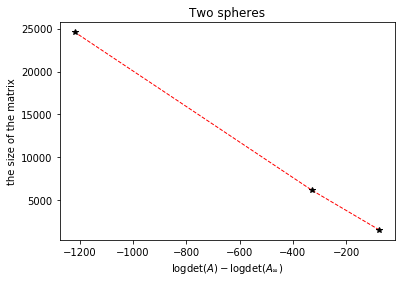

In [138]:
AA = [AA3,AA4,AA5]
BB= [BB3,BB4,BB5]
plt.plot(AA,BB, color='red',linewidth=1.0,linestyle='--')
plt.plot(AA,BB,'k*')
plt.xlabel('$\log\det(A)-\log\det(A_{\infty})$')
plt.ylabel('the size of the matrix')
plt.title('Two spheres')

Text(0, 0.5, 'the size of the matrix')

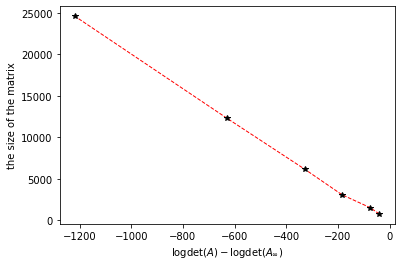

In [137]:
AA = [A3,AA3,A4,AA4,A5,AA5]
BB= [B3, BB3,B4, BB4,B5,BB5]
plt.plot(AA,BB, color='red',linewidth=1.0,linestyle='--')
plt.plot(AA,BB,'k*')
plt.xlabel('$\log\det(A)-\log\det(A_{\infty})$')
plt.ylabel('the size of the matrix')